In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.interpolate import bisplrep, bisplev
import torch

## Generate a very simple image to segment

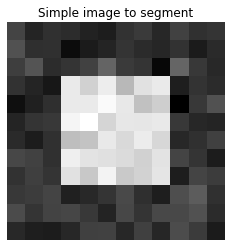

In [2]:
#Make a canvas
H = W = 12
clean_img = np.zeros((W, H), dtype=np.float32)
#Fill in a square!
clean_img[3:-3, 3:-3] = 1.0

img = clean_img + np.random.randn(*clean_img.shape)/10
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)

plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('Simple image to segment');

## Generate a cubic spline that spans this space

### Start by initializing some potiential function

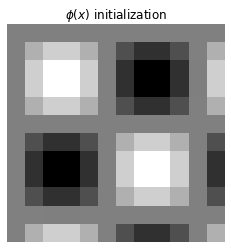

In [3]:
#Make the sinusoidal initialization https://www.ipol.im/pub/art/2012/g-cv/article.pdf Eq 15. 
x = np.arange(W)
y = np.arange(H)

X,Y = np.meshgrid(x,y)

phi_0 = np.sin(np.pi/5 * X)* np.sin(np.pi/5*Y)

# phi_0 = np.random.uniform(-1,1,size = [W,H])
plt.imshow(phi_0,cmap='gray')
plt.title("$\phi(x)$ initialization")
plt.axis('off');

### Make a DCT representation of this potential

Text(0.5, 1.0, 'DCT basis recovery')

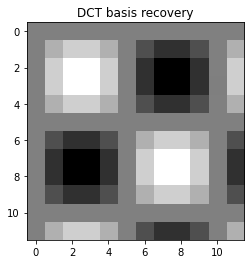

In [4]:
#Get 2d dct of inputs
from scipy.fftpack import dctn,idctn,idct,idst
from scipy.fft import dct
coefs = dctn(phi_0,norm='ortho')
D = idct(np.eye(H),norm='ortho')
recovered = D.T@coefs@D
plt.imshow(recovered,cmap='gray')
plt.title('DCT basis recovery')


### Get x and y gradients

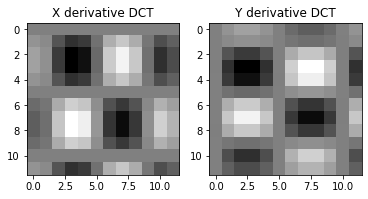

In [5]:
DS = idst(np.eye(H),norm='ortho')
plt.subplot(1,2,1)
xgrad = -D.T@coefs@DS
plt.imshow(xgrad,cmap='gray')
plt.title('X derivative DCT')
plt.subplot(1,2,2)
ygrad = -DS.T@coefs@D
plt.imshow(ygrad,cmap='gray')
plt.title('Y derivative DCT');

# Evaluate the energy function at image points

arg$\min_{c_1,c_2,c[k]} \int_\Omega \delta(\phi(x)) |\nabla \phi(x;c[k])|dx + \int_\Omega |f(x) - c_1|^2 H(\phi(x;c[k]))dx + \int_\Omega |f(x) - c_2|^2 (1-H(\phi(x;c[k])))dx$

For this toy problem, we assume that $c_1$ = white = 1, $c_2$ = black = 0, and try to optimize over $c[k]$

## Define weak Heaviside and weak Dirac delta

In [6]:
def regularizedHeaviside(x,epsilon=1):
    return .5*(1+(2/np.pi)*np.arctan(x/epsilon))
def regularizedDelta(x,epsilon=1):
    return epsilon/(np.pi*((epsilon**2)+(x**2)))

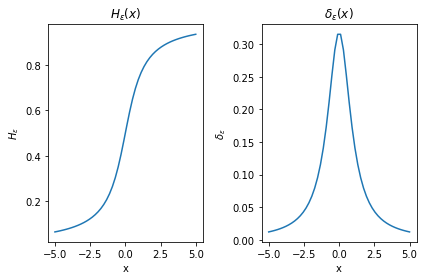

In [7]:
x = np.linspace(-5,5)
plt.subplot(121)
plt.plot(x,regularizedHeaviside(x))
plt.title('$H_{\epsilon}(x)$')
plt.xlabel('x')
plt.ylabel('$H_{\epsilon}$')

plt.subplot(122)
plt.plot(x,regularizedDelta(x))
plt.title('$\delta_{\epsilon}(x)$')
plt.xlabel('x')
plt.ylabel('$\delta_{\epsilon}$');
plt.tight_layout()

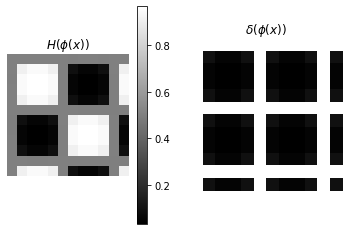

In [8]:
#First evaluate spline at image points (see above for ideas)
dct_vals =  D.T@coefs@D
#Just look at results of heaviside and delta on these values
plt.subplot(121)
plt.imshow(regularizedHeaviside(dct_vals,epsilon=.1),cmap='gray')
plt.title('$H(\phi(x))$')
plt.axis('off')
plt.colorbar()
plt.subplot(122)
plt.imshow(regularizedDelta(dct_vals,epsilon=.1),cmap='gray')
plt.title('$\delta(\phi(x))$')
plt.axis('off');

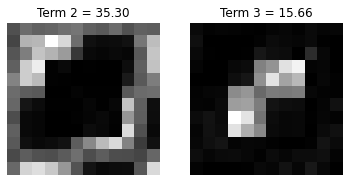

In [9]:
#Intialize ground truth black and white
c1 = 1
c0 = 0
# Evaluate Spline
dct_vals =  D.T@coefs@D
#Start with second and third terms
plt.subplot(121)
term2 = np.square(img-c1)*regularizedHeaviside(dct_vals,epsilon=.1)
plt.imshow(term2,cmap='gray')
plt.axis('off');
plt.title(f"Term 2 = {term2.sum():.2f}");
plt.subplot(122)
term3 = np.square(img-c0)*(1-regularizedHeaviside(dct_vals,epsilon=.1))
plt.imshow(term3,cmap='gray')
plt.axis('off');
plt.title(f"Term 3 = {term3.sum():.2f}");

## Implement the first term , which corresponds to the length penalty

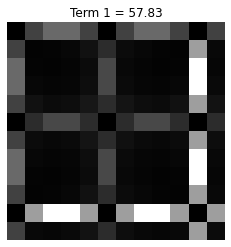

In [10]:
#Evaluate x and y derivatives of the spline at pixel locations
xgrad = -D.T@coefs@DS 
ygrad = -DS.T@coefs@D
# xgrad = spline.ev(X,Y,dx=1)
# ygrad = spline.ev(X,Y,dy=1)
#Concatenate these to determine the magnitude of the gradient 
combinedGrad = np.stack([xgrad,ygrad],axis=-1)
maggrad = np.linalg.norm(np.stack([xgrad,ygrad],axis=-1),axis=-1)
# Get term1
term1 = regularizedDelta(dct_vals,epsilon=.1)*maggrad
plt.imshow(term1,cmap='gray')
plt.axis('off');
plt.title(f"Term 1 = {term1.sum():.2f}");

## Plot all of the terms together!

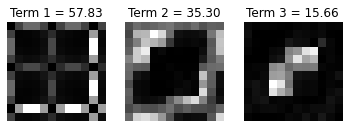

In [11]:
plt.subplot(131)
plt.imshow(term1,cmap='gray')
plt.axis('off');
plt.title(f"Term 1 = {term1.sum():.2f}");
plt.subplot(132)
plt.imshow(term2,cmap='gray')
plt.axis('off');
plt.title(f"Term 2 = {term2.sum():.2f}");
plt.subplot(133)
plt.imshow(term3,cmap='gray')
plt.axis('off');
plt.title(f"Term 3 = {term3.sum():.2f}");

# Implementation of the optimization loop

In [12]:
## Create a loss function
def TwoColorSegmentationLoss(ck,lmda1= 0,lmda2 =1e-2):
    ck = ck.reshape(D.shape)
    dct_vals =  D.T@coefs@D
    xgrad = -D.T@coefs@DS 
    ygrad = -DS.T@coefs@D
    
    #Compute first term
    combinedGrad = np.stack([xgrad,ygrad],axis=-1)
    maggrad = np.linalg.norm(np.stack([xgrad,ygrad],axis=-1),axis=-1)
    # Get term1
    term1 = (regularizedDelta(dct_vals,epsilon=.1)*maggrad).sum()
    
    #Compute second term
    term2 = (np.square(img-c1)*regularizedHeaviside(dct_vals,epsilon=.1)).sum()

    #Compute third term
    term3 = (np.square(img-c0)*(1-regularizedHeaviside(dct_vals,epsilon=.1))).sum()
    
    #Compute 4th term (regularize the values of the coefficients?)
    term4 = np.linalg.norm(coefs)
    return lmda1*term1 + term2+term3 + term4*lmda2

In [13]:
import torch
from torch.nn import functional as F
import torch.nn as nn

In [14]:
D = torch.tensor(D,dtype = torch.float32)
DS = torch.tensor(DS,dtype= torch.float32)
ck = torch.tensor(coefs,dtype= torch.float32,requires_grad = True)
img = torch.tensor(img,dtype = torch.float32)

In [15]:
def regularizedHeaviside(x,epsilon=1):
    return .5*(1+(2/torch.pi)*torch.arctan(x/epsilon))
def regularizedDelta(x,epsilon=1):
    return epsilon/(torch.pi*((epsilon**2)+(x**2)))

In [16]:
def forward(lmda1= 0,lmda2 =1e-2):
    dct_vals =  D.T@ck@D
    xgrad = -D.T@ck@DS 
    ygrad = -DS.T@ck@D
    
    #Compute first term
    combinedGrad = torch.stack([xgrad,ygrad],axis=-1)
    maggrad = torch.linalg.norm(torch.stack([xgrad,ygrad],axis=-1),axis=-1)
    # Get term1
    term1 = (regularizedDelta(dct_vals,epsilon=.1)*maggrad).sum()
    
    #Compute second term
    term2 = (torch.square(img-c1)*regularizedHeaviside(dct_vals,epsilon=.1)).sum()

    #Compute third term
    term3 = (torch.square(img-c0)*(1-regularizedHeaviside(dct_vals,epsilon=.1))).sum()
    
    #Compute 4th term (regularize the values of the coefficients?)
    term4 = torch.linalg.norm(ck)
    return lmda1*term1 + term2+term3 + term4*lmda2

def loss(err):
    return err.mean()

In [17]:
# D.T@ck@D

In [18]:
ck = torch.tensor(coefs,dtype= torch.float32,requires_grad = True)


In [19]:
lr = 1
optimizer = torch.optim.Adam([ck],lr = lr)
niter=10000
for epoch in range(niter):
    err = forward()
    l = loss(err)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 1000 == 0:
        print(f'epoch {epoch+1}, loss = {l.item():.8f}')

epoch 1, loss = 51.02043152
epoch 1001, loss = 7.33336973
epoch 2001, loss = 6.80951691
epoch 3001, loss = 6.80947447
epoch 4001, loss = 6.80947495
epoch 5001, loss = 6.80947447
epoch 6001, loss = 6.80947495
epoch 7001, loss = 6.80947495
epoch 8001, loss = 6.80947495
epoch 9001, loss = 6.80947495


In [20]:
def get_img(coefs):
    coefs = coefs.reshape(D.shape)
    return D.T@coefs@D

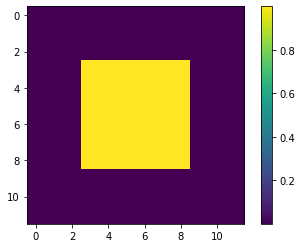

In [21]:
dct_vals = get_img(ck.detach().numpy())
dct_vals = dct_vals
# spline_vals = np.clip(spline_vals,-10,10)
plt.imshow(regularizedHeaviside(dct_vals,epsilon=.001))
plt.colorbar()

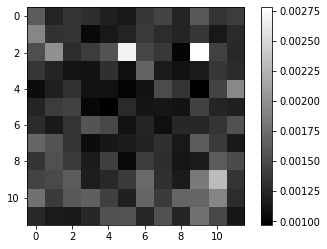

In [22]:
plt.imshow(regularizedDelta(dct_vals,epsilon=.1),cmap='gray')
plt.colorbar()

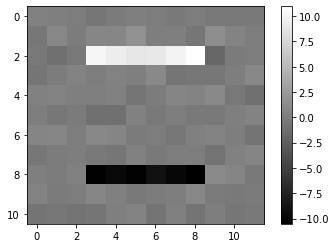

In [23]:
plt.imshow(dct_vals[1:,:]-dct_vals[:-1,:],cmap='gray')
plt.colorbar()

Text(0.5, 1.0, 'Segmented Image')

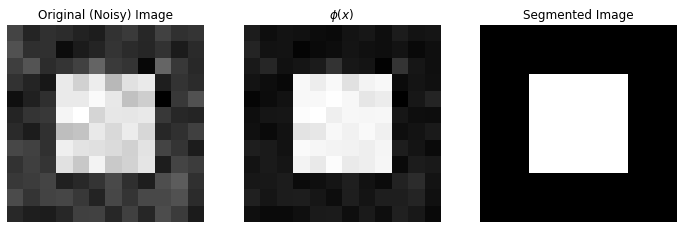

In [30]:
plt.figure(figsize=[12,12])
plt.subplot(131)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('Original (Noisy) Image')
plt.subplot(132)
plt.imshow(dct_vals,cmap='gray')
# plt.colorbar()
plt.title('$\phi(x)$')
plt.axis('off')
plt.subplot(133)
plt.imshow(regularizedHeaviside(dct_vals,epsilon=.001),cmap='gray')
plt.axis('off')
plt.title('Segmented Image')


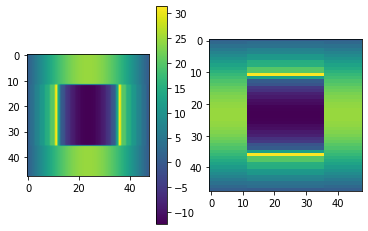

In [25]:
xgrad = -D.T@ck@DS 
ygrad = -DS.T@ck@D
plt.subplot(121)
plt.imshow(xgrad.detach().numpy())
plt.colorbar()
plt.subplot(122)
plt.imshow(ygrad.detach().numpy())

Text(0.5, 1.0, 'Y-axis DCT basis')

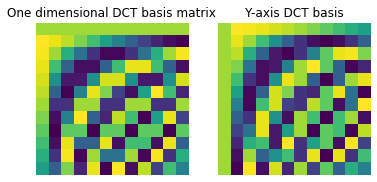

In [26]:
plt.imshow(ck.detach().numpy())
plt.colorbar()
plt.subplot(121)
plt.axis('off')
plt.title('One dimensional DCT basis matrix')
plt.imshow(D)
plt.subplot(122)
plt.imshow(D.T)
plt.axis('off')
plt.title('Y-axis DCT basis')